# Observed Dew Point vs PBL1 + print of observed data values

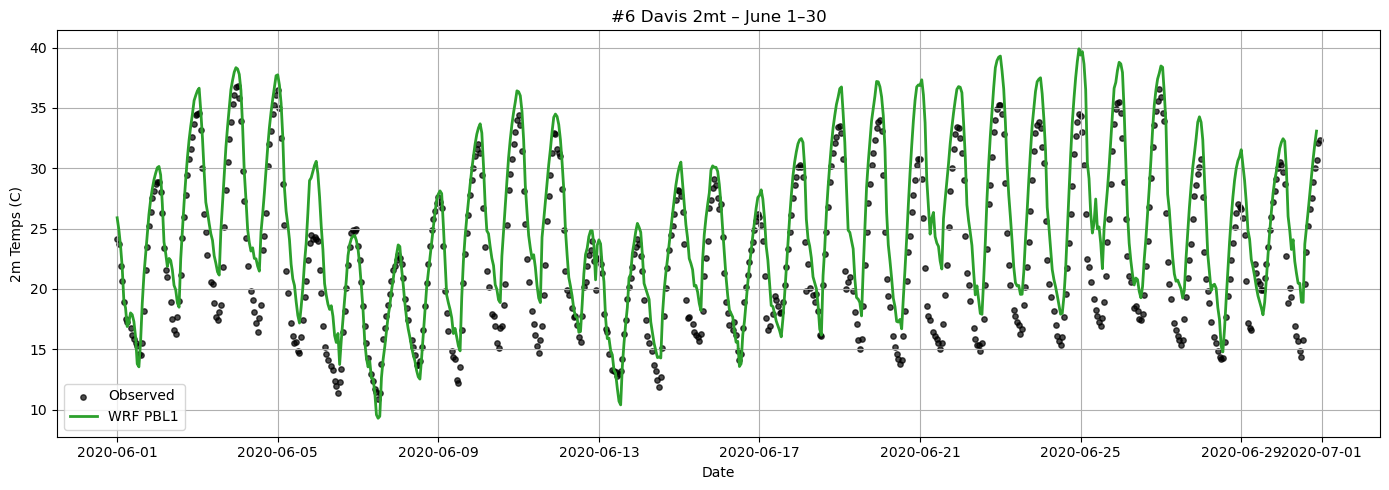

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES
from glob import glob

# === Target location ===
lat_point = 38.535694
lon_point = -121.77636

# === WRF Settings ===
Var = "T2"
VarLabel = "2m Temps (C)"
data_paths = [("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1/", "WRF PBL1","tab:green")]

# === Containers ===
Var_all = [[] for _ in data_paths]
Time_all = []

# === Get files and grid index ===
all_files = [sorted(glob(f"{path}/wrfout_d01_2020-06-*")) for path, _, _ in data_paths]
sample_ds = Dataset(all_files[0][0])
x_idx, y_idx = map(int, ll_to_xy(sample_ds, lat_point, lon_point, as_int=True))

# === WRF file loop ===
for file_i in range(len(all_files[0])):
    datasets = [Dataset(files[file_i]) for files in all_files]

    time_vals = getvar(datasets[0], "times", timeidx=ALL_TIMES)
    time_vals_np = to_np(time_vals)

    if np.isscalar(time_vals_np):
        time_vals_np = [time_vals_np]
    elif isinstance(time_vals_np, np.ndarray) and time_vals_np.ndim == 0:
        time_vals_np = [time_vals_np.item()]
    else:
        time_vals_np = list(time_vals_np)

    for t, time_val in enumerate(time_vals_np):
        Time_all.append(pd.to_datetime(str(time_val)))

        for j, ds in enumerate(datasets):
            var = getvar(ds, Var, timeidx=ALL_TIMES)
            var_np = to_np(var)

            if var_np.ndim == 3:
                value = var_np[t, y_idx, x_idx]- 273.15
            elif var_np.ndim == 2:
                value = var_np[y_idx, x_idx]- 273.15
            else:
                raise ValueError(f"Unexpected var shape: {var_np.shape}")

            Var_all[j].append(value)


# === Filter WRF June data ===
Time_all = pd.to_datetime(Time_all)
time_range_june1_30 = (Time_all >= pd.Timestamp("2020-06-01")) & (Time_all < pd.Timestamp("2020-07-01"))

# === Load and parse observed data ===
df = pd.read_csv("/home/mpasillaspablo/CIMIS/6_Davis_hly2020.csv", dtype=str)

# -- Combine and clean 'Date' + 'Hour' (or similar) columns --
# Example: columns are "Date" and "Hour" separately
date_strs = df["Date"].str.strip()
hour_strs = df["Hour (PST)"].str.zfill(4).str.replace(r"(\d{2})(\d{2})", r"\1:\2", regex=True)

# Localize to US/Pacific (PDT in June), then convert to UTC
dt_local = pd.to_datetime(date_strs + " " + hour_strs, format="%m/%d/%Y %H:%M", errors="coerce")
df["DateTime"] = dt_local.dt.tz_localize("America/Los_Angeles", ambiguous="NaT", nonexistent="NaT").dt.tz_convert("UTC").dt.tz_localize(None)


# -- Extract and clean Dew Point values --
raw_2mt = df.iloc[:, 14].str.extract(r"(-?\d{1,3}(?:\.\d)?)")[0]
valid_2mt = pd.to_numeric(raw_2mt, errors="coerce").dropna()



df_valid = df.loc[valid_2mt.index].copy()
df_valid["2m Temps (C)"] = valid_2mt
df_valid = df_valid.dropna(subset=["DateTime", "2m Temps (C)"])
df_valid = df_valid[(df_valid["DateTime"] >= "2020-06-01") & (df_valid["DateTime"] < "2020-07-01")]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 5))

# Observed (as individual points)
ax.scatter(df_valid["DateTime"], df_valid["2m Temps (C)"],
           color="black", label="Observed", s=15, alpha=0.7)

# WRF (as lines)
for i, (_, label, color) in enumerate(data_paths):
    ax.plot(np.array(Time_all)[time_range_june1_30],
            np.array(Var_all[i])[time_range_june1_30],
            label=label, color=color, linewidth=2)

ax.set_title("#6 Davis 2mt – June 1–30")
ax.set_xlabel("Date")
ax.set_ylabel("2m Temps (C)")
ax.legend(loc="lower left")
ax.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Print the full DataFrame without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_valid[["DateTime", "2m Temps (C)"]])

                DateTime  2m Temps (C)
3640 2020-06-01 00:00:00          24.1
3641 2020-06-01 01:00:00          23.7
3642 2020-06-01 02:00:00          21.9
3643 2020-06-01 03:00:00          20.7
3644 2020-06-01 04:00:00          18.9
3645 2020-06-01 05:00:00          17.5
3646 2020-06-01 06:00:00          17.3
3648 2020-06-01 08:00:00          16.8
3649 2020-06-01 09:00:00          16.2
3650 2020-06-01 10:00:00          15.9
3651 2020-06-01 11:00:00          15.5
3652 2020-06-01 12:00:00          15.3
3653 2020-06-01 13:00:00          14.6
3654 2020-06-01 14:00:00          14.5
3655 2020-06-01 15:00:00          15.5
3656 2020-06-01 16:00:00          18.2
3657 2020-06-01 17:00:00          21.6
3658 2020-06-01 18:00:00          23.5
3659 2020-06-01 19:00:00          25.2
3660 2020-06-01 20:00:00          26.4
3661 2020-06-01 21:00:00          27.5
3662 2020-06-01 22:00:00          28.1
3663 2020-06-01 23:00:00          28.7
3664 2020-06-02 00:00:00          28.9
3665 2020-06-02 01:00:00 

In [19]:
from sklearn.metrics import mean_squared_error

# === Interpolate model data to observation times ===
from scipy.interpolate import interp1d

# Prepare model data (PBL1)
model_times = Time_all[time_range_june1_30]
model_2mt = np.array(Var_all[0])[time_range_june1_30]

# Interpolate model dew to observation timestamps
interp_func = interp1d(pd.to_datetime(model_times).astype(np.int64),
                       model_2mt,
                       kind='linear',
                       bounds_error=False,
                       fill_value="extrapolate")

obs_times = df_valid["DateTime"].astype(np.int64)
model_interp = interp_func(obs_times)

# Prepare observed dew (fully cleaned)
obs_2mt = pd.to_numeric(df_valid["2m Temps (C)"], errors="coerce").dropna().to_numpy()

# === Compute statistics ===
def mean_and_rms(arr):
    arr = np.array(arr)
    return arr.mean(), np.sqrt(np.mean(arr ** 2))

mean_obs, rms_obs = mean_and_rms(obs_2mt)
mean_pbl1, rms_pbl1 = mean_and_rms(model_interp)

# === RMSE ===
rmse = np.sqrt(mean_squared_error(obs_2mt, model_interp))

# Debug
print("Obs 2mt count:", len(obs_2mt))
print("Model interp count:", len(model_interp))

# === Print results ===
print(f"""Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  {mean_obs:.2f}
  RMS  Dew Point:  {rms_obs:.2f}

WRF PBL1:
  Mean Dew Point:  {mean_pbl1:.2f}
  RMS  Dew Point:  {rms_pbl1:.2f}

RMSE (Model vs Observed):
WRF PBL1: RMSE = {rmse:.2f}
""")

Obs 2mt count: 690
Model interp count: 690
Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  22.62
  RMS  Dew Point:  23.48

WRF PBL1:
  Mean Dew Point:  25.34
  RMS  Dew Point:  26.24

RMSE (Model vs Observed):
WRF PBL1: RMSE = 3.57



# Observed Dew vs PBL5

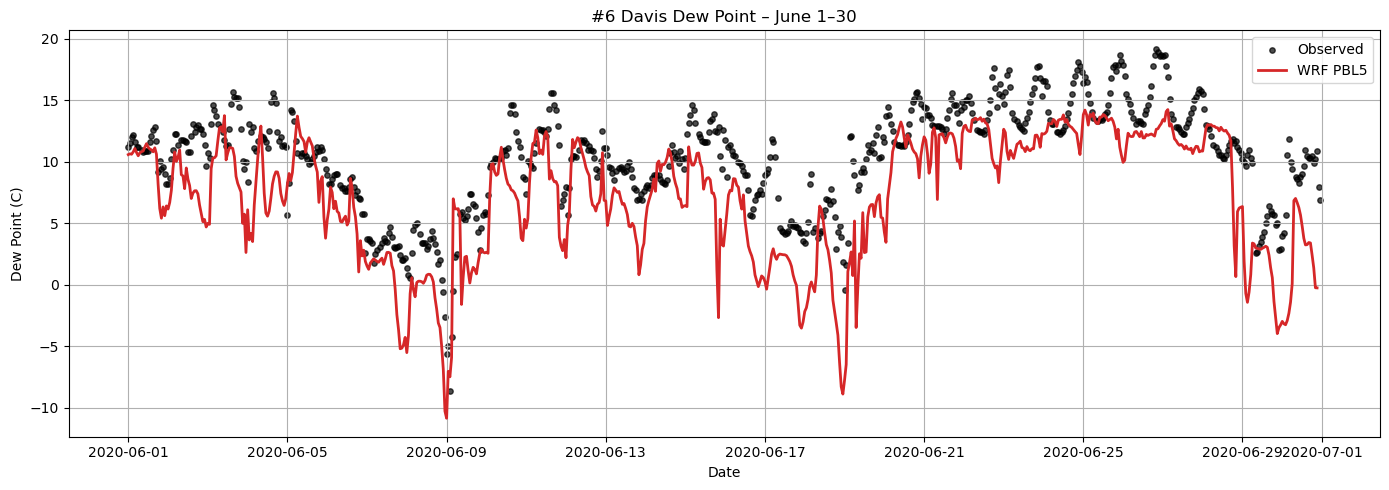

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES
from glob import glob

# === Target location ===
lat_point = 38.535694
lon_point = -121.77636

# === WRF Settings ===
Var = "td2"
VarLabel = "Dew Point (C)"
data_paths = [("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5/", "WRF PBL5","tab:red")]

# === Containers ===
Var_all = [[] for _ in data_paths]
Time_all = []

# === Get files and grid index ===
all_files = [sorted(glob(f"{path}/wrfout_d01_2020-06-*")) for path, _, _ in data_paths]
sample_ds = Dataset(all_files[0][0])
x_idx, y_idx = map(int, ll_to_xy(sample_ds, lat_point, lon_point, as_int=True))

# === WRF file loop ===
for file_i in range(len(all_files[0])):
    datasets = [Dataset(files[file_i]) for files in all_files]

    time_vals = getvar(datasets[0], "times", timeidx=ALL_TIMES)
    time_vals_np = to_np(time_vals)

    if np.isscalar(time_vals_np):
        time_vals_np = [time_vals_np]
    elif isinstance(time_vals_np, np.ndarray) and time_vals_np.ndim == 0:
        time_vals_np = [time_vals_np.item()]
    else:
        time_vals_np = list(time_vals_np)

    for t, time_val in enumerate(time_vals_np):
        Time_all.append(pd.to_datetime(str(time_val)))

        for j, ds in enumerate(datasets):
            var = getvar(ds, Var, timeidx=ALL_TIMES)
            var_np = to_np(var)

            if var_np.ndim == 3:
                value = var_np[t, y_idx, x_idx]
            elif var_np.ndim == 2:
                value = var_np[y_idx, x_idx]
            else:
                raise ValueError(f"Unexpected var shape: {var_np.shape}")

            Var_all[j].append(value)


# === Filter WRF June data ===
Time_all = pd.to_datetime(Time_all)
time_range_june1_30 = (Time_all >= pd.Timestamp("2020-06-01")) & (Time_all < pd.Timestamp("2020-07-01"))

# === Load and parse observed data ===
df = pd.read_csv("/home/mpasillaspablo/CIMIS/6_Davis_hly2020.csv", dtype=str)

# -- Combine and clean 'Date' + 'Hour' (or similar) columns --
# Example: columns are "Date" and "Hour" separately
date_strs = df["Date"].str.strip()
hour_strs = df["Hour (PST)"].str.zfill(4).str.replace(r"(\d{2})(\d{2})", r"\1:\2", regex=True)

# Localize to US/Pacific (PDT in June), then convert to UTC
dt_local = pd.to_datetime(date_strs + " " + hour_strs, format="%m/%d/%Y %H:%M", errors="coerce")
df["DateTime"] = dt_local.dt.tz_localize("America/Los_Angeles", ambiguous="NaT", nonexistent="NaT").dt.tz_convert("UTC").dt.tz_localize(None)


# -- Extract and clean Dew Point values --
raw_dew = df.iloc[:, 18].str.extract(r"(-?\d{1,3}(?:\.\d)?)")[0]
valid_dew = pd.to_numeric(raw_dew, errors="coerce").dropna()


df_valid = df.loc[valid_dew.index].copy()
df_valid["Dew Point (C)"] = valid_dew
df_valid = df_valid.dropna(subset=["DateTime", "Dew Point (C)"])
df_valid = df_valid[(df_valid["DateTime"] >= "2020-06-01") & (df_valid["DateTime"] < "2020-07-01")]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 5))

# Observed (as individual points)
ax.scatter(df_valid["DateTime"], df_valid["Dew Point (C)"],
           color="black", label="Observed", s=15, alpha=0.7)

# WRF (as lines)
for i, (_, label, color) in enumerate(data_paths):
    ax.plot(np.array(Time_all)[time_range_june1_30],
            np.array(Var_all[i])[time_range_june1_30],
            label=label, color=color, linewidth=2)

ax.set_title("#6 Davis Dew Point – June 1–30")
ax.set_xlabel("Date")
ax.set_ylabel("Dew Point (C)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error

# === Interpolate model data to observation times ===
from scipy.interpolate import interp1d

# Prepare model data (PBL1)
model_times = Time_all[time_range_june1_30]
model_dew = np.array(Var_all[0])[time_range_june1_30]

# Interpolate model dew to observation timestamps
interp_func = interp1d(pd.to_datetime(model_times).astype(np.int64),
                       model_dew,
                       kind='linear',
                       bounds_error=False,
                       fill_value="extrapolate")

obs_times = df_valid["DateTime"].astype(np.int64)
model_interp = interp_func(obs_times)

# Prepare observed dew (fully cleaned)
obs_dew = pd.to_numeric(df_valid["Dew Point (C)"], errors="coerce").dropna().to_numpy()

# === Compute statistics ===
def mean_and_rms(arr):
    arr = np.array(arr)
    return arr.mean(), np.sqrt(np.mean(arr ** 2))

mean_obs, rms_obs = mean_and_rms(obs_dew)
mean_pbl1, rms_pbl1 = mean_and_rms(model_interp)

# === RMSE ===
rmse = np.sqrt(mean_squared_error(obs_dew, model_interp))

# Debug
print("Obs dew count:", len(obs_dew))
print("Model interp count:", len(model_interp))

# === Print results ===
print(f"""Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  {mean_obs:.2f}
  RMS  Dew Point:  {rms_obs:.2f}

WRF PBL5:
  Mean Dew Point:  {mean_pbl1:.2f}
  RMS  Dew Point:  {rms_pbl1:.2f}

RMSE (Model vs Observed):
WRF PBL5: RMSE = {rmse:.2f}
""")

Obs dew count: 690
Model interp count: 690
Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  10.38
  RMS  Dew Point:  11.19

WRF PBL5:
  Mean Dew Point:  7.01
  RMS  Dew Point:  8.65

RMSE (Model vs Observed):
WRF PBL5: RMSE = 4.52



# Observed Dew vs PBL7

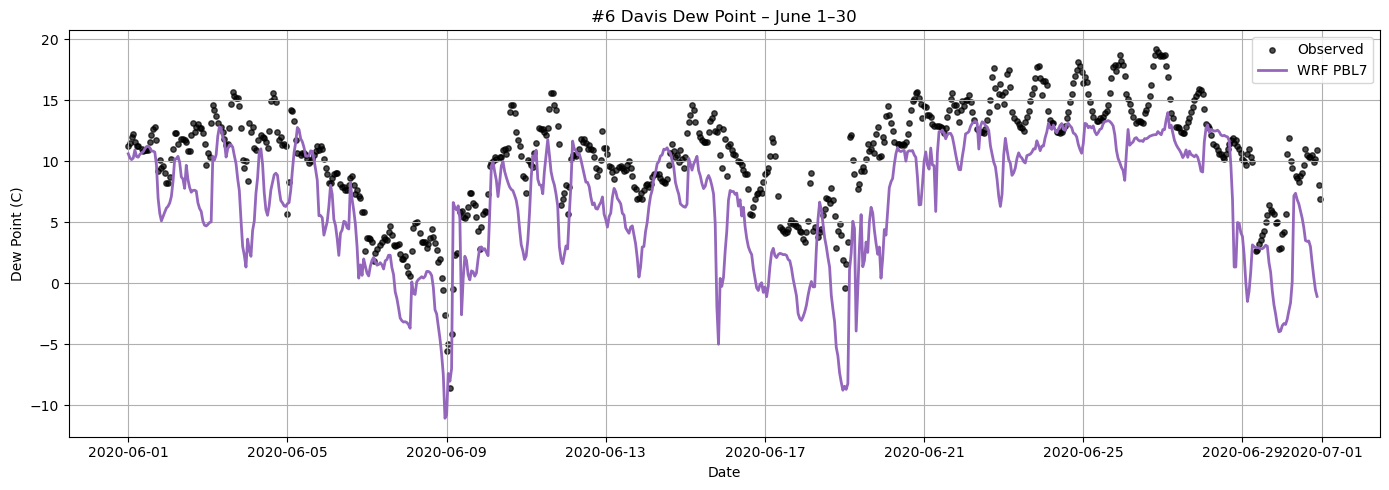

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES
from glob import glob

# === Target location ===
lat_point = 38.535694
lon_point = -121.77636

# === WRF Settings ===
Var = "td2"
VarLabel = "Dew Point (C)"
data_paths = [("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7/", "WRF PBL7","tab:purple")]

# === Containers ===
Var_all = [[] for _ in data_paths]
Time_all = []

# === Get files and grid index ===
all_files = [sorted(glob(f"{path}/wrfout_d01_2020-06-*")) for path, _, _ in data_paths]
sample_ds = Dataset(all_files[0][0])
x_idx, y_idx = map(int, ll_to_xy(sample_ds, lat_point, lon_point, as_int=True))

# === WRF file loop ===
for file_i in range(len(all_files[0])):
    datasets = [Dataset(files[file_i]) for files in all_files]

    time_vals = getvar(datasets[0], "times", timeidx=ALL_TIMES)
    time_vals_np = to_np(time_vals)

    if np.isscalar(time_vals_np):
        time_vals_np = [time_vals_np]
    elif isinstance(time_vals_np, np.ndarray) and time_vals_np.ndim == 0:
        time_vals_np = [time_vals_np.item()]
    else:
        time_vals_np = list(time_vals_np)

    for t, time_val in enumerate(time_vals_np):
        Time_all.append(pd.to_datetime(str(time_val)))

        for j, ds in enumerate(datasets):
            var = getvar(ds, Var, timeidx=ALL_TIMES)
            var_np = to_np(var)

            if var_np.ndim == 3:
                value = var_np[t, y_idx, x_idx]
            elif var_np.ndim == 2:
                value = var_np[y_idx, x_idx]
            else:
                raise ValueError(f"Unexpected var shape: {var_np.shape}")

            Var_all[j].append(value)


# === Filter WRF June data ===
Time_all = pd.to_datetime(Time_all)
time_range_june1_30 = (Time_all >= pd.Timestamp("2020-06-01")) & (Time_all < pd.Timestamp("2020-07-01"))

# === Load and parse observed data ===
df = pd.read_csv("/home/mpasillaspablo/CIMIS/6_Davis_hly2020.csv", dtype=str)

# -- Combine and clean 'Date' + 'Hour' (or similar) columns --
# Example: columns are "Date" and "Hour" separately
date_strs = df["Date"].str.strip()
hour_strs = df["Hour (PST)"].str.zfill(4).str.replace(r"(\d{2})(\d{2})", r"\1:\2", regex=True)

# Localize to US/Pacific (PDT in June), then convert to UTC
dt_local = pd.to_datetime(date_strs + " " + hour_strs, format="%m/%d/%Y %H:%M", errors="coerce")
df["DateTime"] = dt_local.dt.tz_localize("America/Los_Angeles", ambiguous="NaT", nonexistent="NaT").dt.tz_convert("UTC").dt.tz_localize(None)


# -- Extract and clean Dew Point values --
raw_dew = df.iloc[:, 18].str.extract(r"(-?\d{1,3}(?:\.\d)?)")[0]
valid_dew = pd.to_numeric(raw_dew, errors="coerce").dropna()


df_valid = df.loc[valid_dew.index].copy()
df_valid["Dew Point (C)"] = valid_dew
df_valid = df_valid.dropna(subset=["DateTime", "Dew Point (C)"])
df_valid = df_valid[(df_valid["DateTime"] >= "2020-06-01") & (df_valid["DateTime"] < "2020-07-01")]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 5))

# Observed (as individual points)
ax.scatter(df_valid["DateTime"], df_valid["Dew Point (C)"],
           color="black", label="Observed", s=15, alpha=0.7)

# WRF (as lines)
for i, (_, label, color) in enumerate(data_paths):
    ax.plot(np.array(Time_all)[time_range_june1_30],
            np.array(Var_all[i])[time_range_june1_30],
            label=label, color=color, linewidth=2)

ax.set_title("#6 Davis Dew Point – June 1–30")
ax.set_xlabel("Date")
ax.set_ylabel("Dew Point (C)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import mean_squared_error

# === Interpolate model data to observation times ===
from scipy.interpolate import interp1d

# Prepare model data (PBL1)
model_times = Time_all[time_range_june1_30]
model_dew = np.array(Var_all[0])[time_range_june1_30]

# Interpolate model dew to observation timestamps
interp_func = interp1d(pd.to_datetime(model_times).astype(np.int64),
                       model_dew,
                       kind='linear',
                       bounds_error=False,
                       fill_value="extrapolate")

obs_times = df_valid["DateTime"].astype(np.int64)
model_interp = interp_func(obs_times)

# Prepare observed dew (fully cleaned)
obs_dew = pd.to_numeric(df_valid["Dew Point (C)"], errors="coerce").dropna().to_numpy()

# === Compute statistics ===
def mean_and_rms(arr):
    arr = np.array(arr)
    return arr.mean(), np.sqrt(np.mean(arr ** 2))

mean_obs, rms_obs = mean_and_rms(obs_dew)
mean_pbl1, rms_pbl1 = mean_and_rms(model_interp)

# === RMSE ===
rmse = np.sqrt(mean_squared_error(obs_dew, model_interp))

# Debug
print("Obs dew count:", len(obs_dew))
print("Model interp count:", len(model_interp))

# === Print results ===
print(f"""Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  {mean_obs:.2f}
  RMS  Dew Point:  {rms_obs:.2f}

WRF PBL7:
  Mean Dew Point:  {mean_pbl1:.2f}
  RMS  Dew Point:  {rms_pbl1:.2f}

RMSE (Model vs Observed):
WRF PBL7: RMSE = {rmse:.2f}
""")

Obs dew count: 690
Model interp count: 690
Mean and RMS Dew Point : 
Observed:
  Mean Dew Point:  10.38
  RMS  Dew Point:  11.19

WRF PBL1:
  Mean Dew Point:  6.39
  RMS  Dew Point:  8.14

RMSE (Model vs Observed):
WRF PBL1: RMSE = 5.05



# Observed 2m RH vs PBL 1, 5, & 7

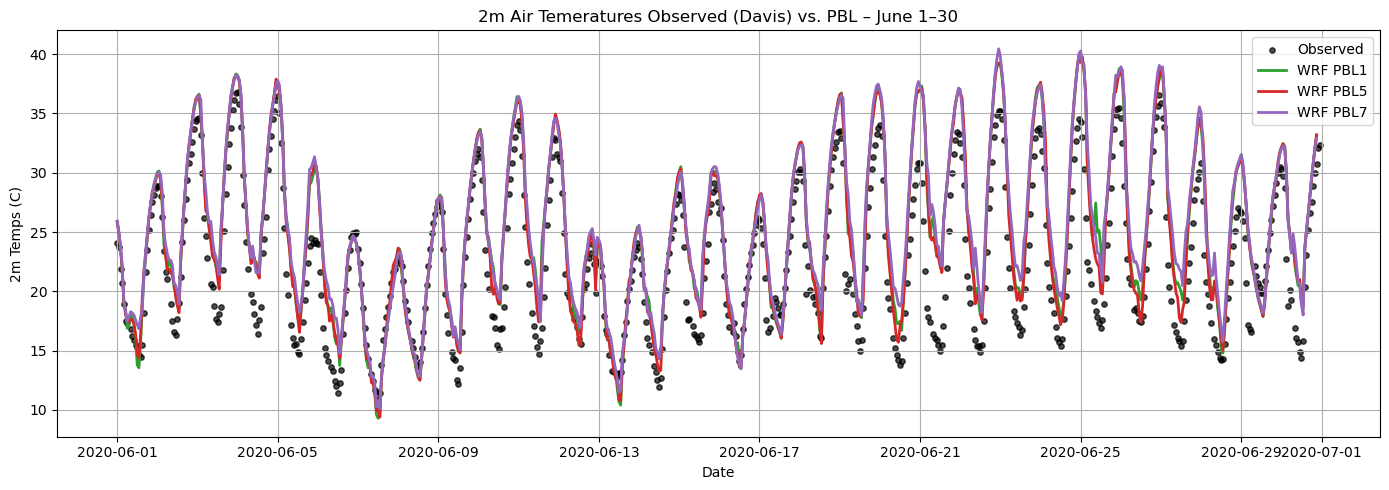

3640    24.1
3641    23.7
3642    21.9
3643    20.7
3644    18.9
        ... 
4355    28.9
4356    30.0
4357    30.7
4358    32.1
4359    32.3
Name: 2m Temps (C), Length: 690, dtype: float64


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, to_np, ll_to_xy, ALL_TIMES
from glob import glob

# === Target location ===
lat_point = 38.535694
lon_point = -121.77636

# === WRF Settings ===
Var = "T2"
VarLabel = "2m Temps (C)"
data_paths = [
    ("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1/", "WRF PBL1", 'tab:green'),
    ("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5/", "WRF PBL5", 'tab:red'),
    ("/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7/", "WRF PBL7", 'tab:purple')
]

# === Containers ===
Var_all = [[] for _ in data_paths]
Time_all = []

# === Get files and grid index ===
all_files = [sorted(glob(f"{path}/wrfout_d01_2020-06-*")) for path, _, _ in data_paths]
sample_ds = Dataset(all_files[0][0])
x_idx, y_idx = map(int, ll_to_xy(sample_ds, lat_point, lon_point, as_int=True))

# === WRF file loop ===
for file_i in range(len(all_files[0])):
    datasets = [Dataset(files[file_i]) for files in all_files]

    time_vals = getvar(datasets[0], "times", timeidx=ALL_TIMES)
    time_vals_np = to_np(time_vals)

    if np.isscalar(time_vals_np):
        time_vals_np = [time_vals_np]
    elif isinstance(time_vals_np, np.ndarray) and time_vals_np.ndim == 0:
        time_vals_np = [time_vals_np.item()]
    else:
        time_vals_np = list(time_vals_np)

    for t, time_val in enumerate(time_vals_np):
        Time_all.append(pd.to_datetime(str(time_val)))

        for j, ds in enumerate(datasets):
            var = getvar(ds, Var, timeidx=ALL_TIMES)
            var_np = to_np(var)

            if var_np.ndim == 3:
                value = var_np[t, y_idx, x_idx]- 273.15
            elif var_np.ndim == 2:
                value = var_np[y_idx, x_idx]- 273.15
            else:
                raise ValueError(f"Unexpected var shape: {var_np.shape}")

            Var_all[j].append(value)


# === Filter WRF June data ===
Time_all = pd.to_datetime(Time_all)
time_range_june1_30 = (Time_all >= pd.Timestamp("2020-06-01")) & (Time_all < pd.Timestamp("2020-07-01"))

# === Load and parse observed data ===
df = pd.read_csv("/home/mpasillaspablo/CIMIS/6_Davis_hly2020.csv", dtype=str)

# -- Combine and clean 'Date' + 'Hour' (or similar) columns --
# Example: columns are "Date" and "Hour" separately
date_strs = df["Date"].str.strip()
hour_strs = df["Hour (PST)"].str.zfill(4).str.replace(r"(\d{2})(\d{2})", r"\1:\2", regex=True)

# Localize to US/Pacific (PDT in June), then convert to UTC
dt_local = pd.to_datetime(date_strs + " " + hour_strs, format="%m/%d/%Y %H:%M", errors="coerce")
df["DateTime"] = dt_local.dt.tz_localize("America/Los_Angeles", ambiguous="NaT", nonexistent="NaT").dt.tz_convert("UTC").dt.tz_localize(None)


# -- Extract and clean dew values --
raw_2mt = df.iloc[:, 14].str.extract(r"(-?\d{1,3}(?:\.\d)?)")[0]
valid_2mt = pd.to_numeric(raw_2mt, errors="coerce").dropna()


df_valid = df.loc[valid_dew.index].copy()
df_valid["2m Temps (C)"] = valid_2mt
df_valid = df_valid.dropna(subset=["DateTime", "2m Temps (C)"])
df_valid = df_valid[(df_valid["DateTime"] >= "2020-06-01") & (df_valid["DateTime"] < "2020-07-01")]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 5))

# Observed (as individual points)
ax.scatter(df_valid["DateTime"], df_valid["2m Temps (C)"],
           color="black", label="Observed", s=15, alpha=0.7)

# WRF (as lines)
for i, (_, label, color) in enumerate(data_paths):
    ax.plot(np.array(Time_all)[time_range_june1_30],
            np.array(Var_all[i])[time_range_june1_30],
            label=label, color=color, linewidth=2)

ax.set_title("2m Air Temeratures Observed (Davis) vs. PBL – June 1–30")
ax.set_xlabel("Date")
ax.set_ylabel("2m Temps (C)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

print(df_valid["2m Temps (C)"])

In [17]:
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

# === Prepare observed dew ===
obs_times = df_valid["DateTime"].astype(np.int64)
obs_2mt = pd.to_numeric(df_valid["2m Temps (C)"], errors="coerce").dropna().to_numpy()

# === Compute mean and RMS ===
def mean_and_rms(arr):
    arr = np.array(arr)
    return arr.mean(), np.sqrt(np.mean(arr ** 2))

# === Observed statistics ===
mean_obs, rms_obs = mean_and_rms(obs_2mt)

# === Model statistics containers ===
mean_vals = []
rms_vals = []
rmse_vals = []

# === Loop over each model ===
for i in range(len(data_paths)):
    model_times = pd.to_datetime(np.array(Time_all)[time_range_june1_30])
    model_2mt = np.array(Var_all[i])[time_range_june1_30]

    # Interpolation
    interp_func = interp1d(model_times.astype(np.int64),
                           model_2mt,
                           kind='linear',
                           bounds_error=False,
                           fill_value="extrapolate")

    model_interp = interp_func(obs_times)

    # Stats
    mean_model, rms_model = mean_and_rms(model_interp)
    rmse_model = np.sqrt(mean_squared_error(obs_2mt, model_interp))

    mean_vals.append(mean_model)
    rms_vals.append(rms_model)
    rmse_vals.append(rmse_model)

# === Print results ===
print("Obs 2mt count:", len(obs_2mt))
print("Model interp count:", len(model_interp))

print(f"""Mean and RMS Dew Point: 
Observed:
  Mean 2mt Point:  {mean_obs:.2f}
  RMS  Dew Point:  {rms_obs:.2f}

WRF PBL1:
  Mean Dew Point:  {mean_vals[0]:.2f}
  RMS  Dew Point:  {rms_vals[0]:.2f}

WRF PBL5:
  Mean Dew Point:  {mean_vals[1]:.2f}
  RMS  Dew Point:  {rms_vals[1]:.2f}

WRF PBL7:
  Mean Dew Point:  {mean_vals[2]:.2f}
  RMS  Dew Point:  {rms_vals[2]:.2f}

RMSE (Model vs Observed):
WRF PBL1: RMSE = {rmse_vals[0]:.2f}
WRF PBL5: RMSE = {rmse_vals[1]:.2f}
WRF PBL7: RMSE = {rmse_vals[2]:.2f}
""")


Obs 2mt count: 690
Model interp count: 690
Mean and RMS Dew Point: 
Observed:
  Mean 2mt Point:  22.62
  RMS  Dew Point:  23.48

WRF PBL1:
  Mean Dew Point:  25.34
  RMS  Dew Point:  26.24

WRF PBL5:
  Mean Dew Point:  25.21
  RMS  Dew Point:  26.13

WRF PBL7:
  Mean Dew Point:  25.72
  RMS  Dew Point:  26.56

RMSE (Model vs Observed):
WRF PBL1: RMSE = 3.57
WRF PBL5: RMSE = 3.42
WRF PBL7: RMSE = 3.92

